# Analysis for Insight Project

## Setup

In [481]:
# import modules
import pandas as pd
import numpy as np
import rootpath
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics
import qgrid
import matplotlib.pyplot as plt

# Set root path for project
path = rootpath.detect()

# Read in data
# Use list comprehension to read in all files
#df = pd.read_csv(f"{path}/data/data_clean.csv", index_col=0).reset_index(drop=True)

# Product type validation
df = pd.read_csv(f"{path}/data/data_clean_prodtype_valid.csv", index_col=0).reset_index(drop=True)

In [482]:
#df.head()
df.shape

(865, 209)

In [483]:
#features = df.copy().set_index('product')
# Old, before dimensionality reduction
features = df.copy().drop(['product_type','brand', 'price','size','ratings', 
                           'total_reviews','link','price_oz'],
                          axis=1).set_index('product')
features.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
product,,,,,,,,,,,,,,,,,,,,,
The Microdelivery Exfoliating Facial Wash,1.131401,-0.593480,-0.689167,-0.678005,0.069789,-0.078592,0.203378,0.126750,-0.046940,0.001794,...,0.090101,-0.012771,-0.010832,0.037430,-0.032025,0.047951,0.121606,-0.058609,-0.007651,-0.026676
AHA/BHA Exfoliating Cleanser,1.742010,-0.899194,-0.467551,-0.275925,0.349551,0.068018,-0.254380,0.075058,0.299695,0.099609,...,0.078394,0.050996,-0.014191,0.027519,-0.033346,0.076360,-0.070220,0.052633,-0.083592,-0.046628
Hydrating Facial Cleanser,1.750019,-0.760973,-0.456640,-0.030855,0.210258,-0.314280,0.058372,-0.327369,0.056567,0.392438,...,0.062204,0.021977,-0.068773,0.054921,0.010454,-0.071830,0.026877,0.046324,-0.031516,0.022022
Anti-Aging Cleansing Gel,1.760319,-0.882299,-0.521638,-0.082087,0.206999,-0.015911,-0.408961,0.138207,0.259280,-0.058567,...,-0.023414,0.064966,-0.026111,-0.045029,0.046057,-0.112780,-0.084622,0.150129,-0.088348,0.056609
Essential-C Cleanser,2.186845,-0.580426,-0.277619,-0.297381,0.393252,-0.154161,-0.451758,0.233356,0.369732,-0.249111,...,-0.124306,0.239839,-0.009855,0.158743,0.072403,0.159779,-0.087761,-0.086488,0.043070,-0.076788


## K-means++

#### Run K-means and determine number of clusters based on silhouette coef

In [484]:
# Set cluster arguments
kmeans_kwargs = {
        "init": "k-means++",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
        }

In [485]:
silhouette_coefficients = []

# Get silhouette coefficient for each cluster out of 50
for cluster in range(2, 30):
    kmeans = KMeans(n_clusters=cluster, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)

#### Plot silhouette coefficients vs. clusters

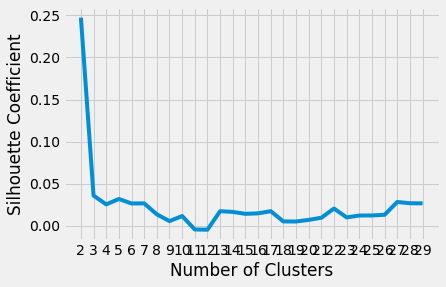

In [486]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), silhouette_coefficients)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
# Add cluster labels to features


## DBSCAN

In [417]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [435]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features)
distances, indices = nbrs.kneighbors(features)

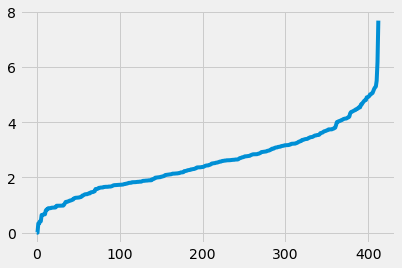

In [436]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [437]:
dbsc = DBSCAN(eps = 5, min_samples = 5).fit(features)
labels = dbsc.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(features, labels))


Estimated number of clusters: 1
Estimated number of noise points: 13
Silhouette Coefficient: 0.335


## Hierarchical/Agglomerative clustering

In [445]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Plot clustering results

n_clusters = 20

# for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
#     model = AgglomerativeClustering(n_clusters=n_clusters,
#                                     linkage="average", affinity=metric)
#     model.fit(features)
#     plt.figure()
#     plt.axes([0, 0, 1, 1])
#     for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
#         plt.plot(features[model.labels_ == l].T, c=c, alpha=.5)
#     plt.axis('tight')
#     plt.axis('off')
#     plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


# plt.show()

cluster = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='ward')  
y_hc =cluster.fit_predict(features)

plt.scatter(features[:,1],features[:,2], c=cluster.labels_, cmap='rainbow')
# plt.scatter(features[y_hc ==0,0], features[y_hc == 0,1], s=100, c='red')
# plt.scatter(features[y_hc==1,0], features[y_hc == 1,1], s=100, c='black')
# plt.scatter(features[y_hc ==2,0], features[y_hc == 2,1], s=100, c='blue')
# plt.scatter(features[y_hc ==3,0], features[y_hc == 3,1], s=100, c='cyan')

TypeError: '(slice(None, None, None), 1)' is an invalid key

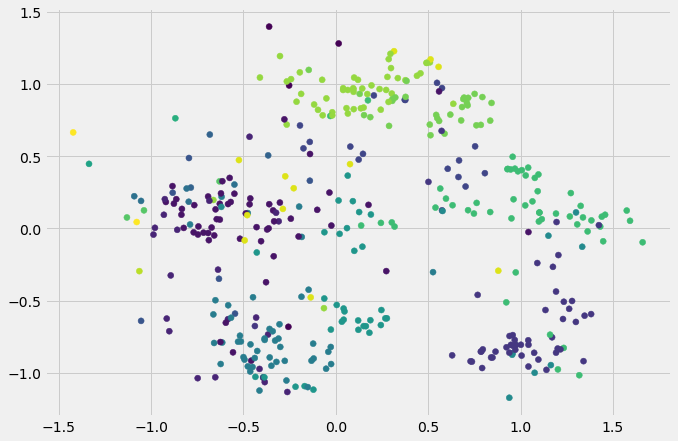

In [441]:
plt.figure(figsize=(10, 7))  
plt.scatter(features['1'], features['2'], c=cluster.labels_) 

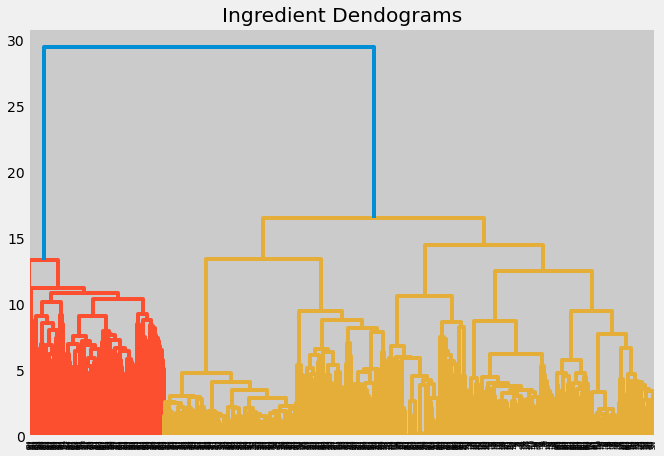

In [487]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Ingredient Dendograms")
dend = shc.dendrogram(shc.linkage(features, method='ward'))

## Gaussian Mixture models

In [457]:
from sklearn.mixture import GaussianMixture as GMM
#from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(features)
labels = gmm.predict(features)

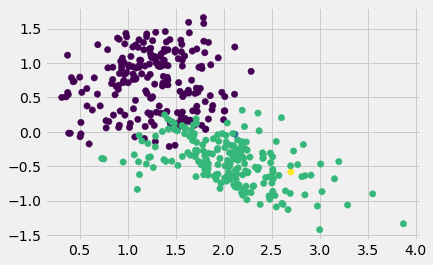

In [458]:
plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=labels, s=40, cmap='viridis')

Text(0.5, 0, 'n_components')

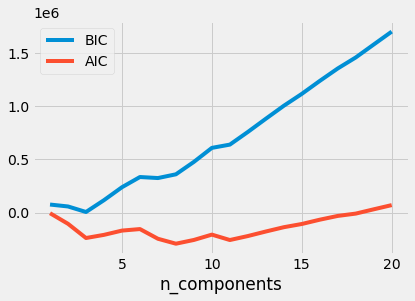

In [456]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(features)
          for n in n_components]

plt.plot(n_components, [m.bic(features) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [ ]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(features)
          for n in n_components]

plt.plot(n_components, [m.bic(features) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

## Pearson correlation

In [459]:
from sklearn.metrics import pairwise_distances

In [465]:
res_pearson = pairwise_distances(features.loc['Gentle Skin Cleanser',:].to_frame().transpose(), features,
                             metric='correlation') #[0:1] .loc["Essential-C Cleanser",:]
res_pearson

array([[0.6659717 , 0.65244956, 0.65833056, 0.64335864, 0.56099857,
        0.4287003 , 0.64115638, 0.65178082, 0.75585038, 0.7784969 ,
        0.37403556, 0.51420108, 0.35650727, 0.6124025 , 0.34853841,
        0.6836847 , 0.72785581, 0.87135438, 0.65260959, 0.65107936,
        0.60936829, 0.71738867, 0.67516719, 0.30237294, 0.7367131 ,
        0.5757427 , 0.61580584, 0.4609563 , 0.43872098, 0.88477554,
        0.58673214, 0.75242958, 0.67046645, 0.42054256, 0.75551712,
        0.83280832, 0.47495109, 0.61112765, 0.65054406, 0.73940975,
        0.7391732 , 0.75976675, 0.3984938 , 0.71547664, 0.68477574,
        0.60670738, 0.71578729, 0.49856663, 0.5815316 , 0.61508239,
        0.66406859, 0.65306131, 0.8609149 , 0.61111591, 0.75656364,
        0.66619389, 0.70578902, 0.71064032, 0.53261339, 0.7726461 ,
        0.27510447, 0.7075833 , 0.61365785, 0.64829463, 0.65780688,
        0.7075833 , 0.53212903, 0.74474819, 0.56340711, 0.55120436,
        0.61752173, 0.66328742, 0.68067665, 0.51

In [466]:
res_pearson = res_pearson.reshape(-1)
res_pearson = pd.DataFrame(res_pearson)
res_sim=df[['product','brand','product_type','price','size','ratings',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_pearson[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nlargest(10, 'similarity')[1:10]
#res_sim.head()
# Select top match
test#[:1]

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,similarity
150,Resveratrol 3% + Ferulic Acid 3%,The Ordinary,face serum,7.9,1.00,4.5,44.0,https://www.ulta.com/resveratrol-3-ferulic-aci...,7.90,1.014276
252,Royal Honey Propolis Enrich Essence,Skinfood,face moisturizer,39.0,1.69,4.6,11.0,https://www.ulta.com/royal-honey-propolis-enri...,23.08,1.010068
129,Hydrating Mist,Juice Beauty,toner,25.0,6.75,3.7,107.0,https://www.ulta.com/hydrating-mist?productId=...,3.70,1.007389
217,Propolis Light Ampule,COSRX,face serum,28.0,1.01,4.4,44.0,https://www.ulta.com/propolis-light-ampule?pro...,27.72,1.005124
154,Advanced Snail 96 Mucin Power Essence,COSRX,face serum,23.0,3.38,4.6,326.0,https://www.ulta.com/advanced-snail-96-mucin-p...,6.80,1.005072
178,Organic Face Serum With Coffee Oil,UpCircle,face serum,20.0,1.00,4.8,494.0,https://www.ulta.com/organic-face-serum-with-c...,20.00,1.003593
146,Turbo Booster C Powder,Philosophy,face serum,39.0,0.25,4.6,178.0,https://www.ulta.com/turbo-booster-c-powder?pr...,156.00,1.002300
153,Future Youth Crystal Ball Serum,Pacifica,face serum,16.0,0.60,4.5,61.0,https://www.ulta.com/future-youth-crystal-ball...,26.67,1.000024
203,Maracuja Oil,Tarte,face serum,48.0,1.70,4.5,1151.0,https://www.ulta.com/maracuja-oil?productId=xl...,28.24,0.999104


## Euclidean similarity

In [467]:
from sklearn.metrics import pairwise_distances
import heapq as hq

In [479]:
res_euc = pairwise_distances(features.loc['Gentle Skin Cleanser',:].to_frame().transpose(), features,
                             metric='euclidean') #[0:1] .loc["Essential-C Cleanser",:]
res_euc

array([[2.51678287, 2.33142432, 2.42849237, 2.3516415 , 2.74855314,
        1.95716933, 2.74452158, 2.89868572, 3.9829232 , 4.29047748,
        1.73297626, 2.42100615, 1.75963736, 2.19047426, 1.84817541,
        3.14575898, 3.51311736, 3.95159575, 2.37246507, 2.36048906,
        2.52256884, 3.45346666, 2.50148726, 1.64919185, 3.63089822,
        2.30893004, 2.65989352, 2.06113448, 1.94171032, 3.97566301,
        2.37263984, 3.82783308, 2.97006306, 1.89642226, 3.99874796,
        3.21055362, 2.4302471 , 2.57463623, 2.29409136, 3.89521447,
        2.39991795, 4.0063986 , 1.82504003, 3.36528216, 3.10630097,
        2.23136259, 3.36952555, 2.29178832, 3.19704216, 2.63099639,
        4.07027635, 3.17384605, 3.65512622, 2.56129209, 3.96560206,
        2.62396166, 4.76051565, 3.34166219, 2.82192039, 4.17852233,
        1.50150605, 3.3618171 , 2.56968273, 2.35973142, 3.7541872 ,
        3.3618171 , 2.15081486, 3.78289062, 2.31771648, 2.93331729,
        2.79883039, 2.93085612, 3.05639757, 2.68

In [480]:
res_euc = res_euc.reshape(-1)
res_euc = pd.DataFrame(res_euc)
res_sim=df[['product','brand','product_type','price','size','ratings',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_euc[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nsmallest(10, 'similarity')[1:10]
#res_sim.head()
# Select top match
test#[:1]

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,similarity
60,Vital Vita 12 Jelly Cleanser,TONYMOLY,face wash,18.00,5.0,4.2,15.0,https://www.ulta.com/vital-vita-12-jelly-clean...,3.60,1.501506
111,Foaming Facial Wash,Curél,face wash,20.00,5.0,4.6,240.0,https://www.ulta.com/foaming-facial-wash?produ...,4.00,1.636158
23,Orange Cleansing Soap,Mario Badescu,face wash,12.00,8.0,4.0,159.0,https://www.ulta.com/orange-cleansing-soap?pro...,1.50,1.649192
87,SkinActive Micellar Cleansing Water All-in-1 C...,Garnier,face wash,4.99,3.3,4.3,1726.0,https://www.ulta.com/skinactive-micellar-clean...,1.51,1.705777
99,AHA/BHA Acne Clearing Gel,Peter Thomas Roth,face wash,54.00,3.4,4.3,77.0,https://www.ulta.com/ahabha-acne-clearing-gel?...,15.88,1.726108
10,SkinActive Micellar Cleansing Water with Rose ...,Garnier,face wash,8.99,13.5,4.7,679.0,https://www.ulta.com/skinactive-micellar-clean...,0.67,1.732976
12,Oil-Free Acne Wash Pink Grapefruit Facial Clea...,Neutrogena,face wash,9.99,6.0,4.0,2646.0,https://www.ulta.com/oil-free-acne-wash-pink-g...,1.66,1.759637
42,All Bright Cleansing Foam Wash,Botanics,face wash,6.99,5.0,4.2,218.0,https://www.ulta.com/all-bright-cleansing-foam...,1.40,1.825040
14,Chamomile Cleansing Lotion,Mario Badescu,face wash,15.00,8.0,3.9,13.0,https://www.ulta.com/chamomile-cleansing-lotio...,1.88,1.848175


## Cosine similarity

In [488]:
from sklearn.metrics.pairwise import cosine_similarity
import heapq as hq

In [500]:
# Calculate cosine similarity for feature 1
res_cosine = cosine_similarity(features.loc['Pore Clean Toner',:].to_frame().transpose(), features) #[0:1] .loc["Essential-C Cleanser",:]
res_cosine = res_cosine.reshape(-1)
res_cosine = pd.DataFrame(res_cosine)
res_sim=df[['product','brand','product_type','price','size','ratings',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_cosine[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nlargest(10, 'similarity')[1:10]
#res_sim.head()
# Select top match
test#[:1]

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,similarity
15,All About Clean Rinse-Off Foaming Cleanser,Clinique,face wash,22.50,5.00,4.7,1368,https://www.ulta.com/all-about-clean-rinse-off...,4.50,0.687966
337,Truffle Therapy Power Duo,SKIN&CO,toner,45.00,13.60,4.4,7,https://www.ulta.com/truffle-therapy-power-duo...,3.31,0.679857
437,Red Energy Recovery Serum,Mamonde,face serum,40.00,1.01,4.5,81,https://www.ulta.com/red-energy-recovery-serum...,39.60,0.670763
69,SkinActive Micellar Cleansing Water All-in-1 M...,Garnier,face wash,8.99,13.50,4.4,483,https://www.ulta.com/skinactive-micellar-clean...,0.67,0.656188
319,CoQ-10 Toner,INDIE LEE,toner,34.00,4.20,4.6,26,https://www.ulta.com/coq-10-toner?productId=pi...,8.10,0.655598
328,Witch Hazel Blemish Clearing Toner,Thayers,toner,14.99,12.00,4.3,19,https://www.ulta.com/witch-hazel-blemish-clear...,1.25,0.654610
322,Rose & Witch Hazel Toner,Mario Badescu,toner,14.00,8.00,4.3,116,https://www.ulta.com/rose-witch-hazel-toner?pr...,1.75,0.653476
505,Hydra-Essentiel Bi-phase Serum,Clarins,face serum,60.00,1.00,4.2,381,https://www.ulta.com/hydra-essentiel-bi-phase-...,60.00,0.646392
324,Hyaluron Skin Essence,Hanskin,toner,25.00,5.07,4.6,129,https://www.ulta.com/hyaluron-skin-essence?pro...,4.93,0.644752


In [358]:
top_sim = res_sim.nlargest(6, 'similarity')[1:6]
#best_sim_score = min(max(top_sim['similarity'] + min(top_sim['price_oz'])))
#best_sim_score
test=top_sim.iloc[0].to_frame().transpose()[['brand','product','price','price_oz','size','link']]

In [359]:
test

,brand,product,price,price_oz,size,link
111,Curél,Foaming Facial Wash,20,4,5,https://www.ulta.com/foaming-facial-wash?produ...


In [370]:
tempdf = df.loc[df['product']==f'{product}']
df.loc[df['product']==f'{product}']

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,0,...,190,191,192,193,194,195,196,197,198,199
111,Foaming Facial Wash,Curél,face wash,20.0,5.0,4.6,240.0,https://www.ulta.com/foaming-facial-wash?produ...,4.0,1.305882,...,0.230863,-0.072649,-0.010053,-0.149319,0.050311,0.018858,0.035698,0.076982,-0.042091,0.05028


In [387]:
price_diff = tempdf['price_oz']-output_rec['price_oz']

In [396]:
tempdf = df.loc[df['product']==f'{product}']
test.iloc[1]['price_oz']
#price_diff = tempdf['price_oz']-test['price_oz']
#price_diff=price_diff.astype('float')
#price_diff
#tempdf['price_oz']
#price_diff
#test=price_diff.values[0]
#test
#f"test price:{test}"

3.6

In [328]:
output_rec = top_sim.iloc[0].to_frame().transpose()[['product_type', 'brand','product','price','price_oz','size','link']]
output_rec

,product_type,brand,product,price,price_oz,size,link
111,face wash,Curél,Foaming Facial Wash,20,4,5,https://www.ulta.com/foaming-facial-wash?produ...


In [411]:
tempdf = df.loc[df['product']==f'{product}']
res_sim
#tempdf
price_diff = tempdf['price_oz']-output_rec['price_oz']
#price_diff
#res_sim['price_oz']
#price_diff
#tempdf['price_oz']#-res_sim['price_oz']
top_sim = res_sim.nlargest(6, 'similarity')[1:6]
output_rec = top_sim.iloc[1].to_frame().transpose()[['product_type', 'brand','product', 'similarity','price','price_oz','size','link']]
output_rec['similarity']=output_rec['similarity'].astype(float)
output_rec['similarity']=round(output_rec['similarity'],2)
#output_rec
#tempdf = df.loc[df['product']==f'{product}']
#tempdf
output_rec['similarity']

60    0.73
Name: similarity, dtype: float64

In [284]:
product_input=df.loc[df['product']==f'{product}']
product_input

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,0,...,190,191,192,193,194,195,196,197,198,199
111,Foaming Facial Wash,Curél,face wash,20.0,5.0,4.6,240.0,https://www.ulta.com/foaming-facial-wash?produ...,4.0,1.305882,...,0.230863,-0.072649,-0.010053,-0.149319,0.050311,0.018858,0.035698,0.076982,-0.042091,0.05028


In [282]:
cosine_similarity(product_input) 

ValueError: could not convert string to float: 'Foaming Facial Wash'

In [259]:
top_sim[:1]

NameError: name 'top_sim' is not defined

In [245]:
(((0.881751+0.766394+0.629398)/3) + ((0.629398+0.526911+0.539059)/3) +
((0.881751+0.757364+0.526911)/3) + ((0.766394+0.757364+0.539059)/3))/4

0.6834795

In [219]:
test
#np.minimum(test['similarity'],test['price_oz'])
min(max(test.similarity),min(test.price_oz))

0.785614939701423

In [141]:
features.index
#features.loc["Essential-C Cleanser",:]  #"'Buffet' + Copper Peptides 1%"
features.loc["Essential-C Cleanser",:].to_frame().transpose()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
Essential-C Cleanser,1.692273,-0.334327,-0.1981,-0.721162,0.311682,0.403308,0.134368,0.140876,-0.073881,0.085826,...,-0.067952,0.092941,-0.085718,0.083519,-0.02647,0.095582,-0.092331,0.176955,-0.006216,-0.021925


In [157]:
features.loc["Essential-C Cleanser",:].to_frame().transpose()
#features.loc[0,["Essential-C Cleanser"]]

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
Essential-C Cleanser,1.692273,-0.334327,-0.1981,-0.721162,0.311682,0.403308,0.134368,0.140876,-0.073881,0.085826,...,-0.067952,0.092941,-0.085718,0.083519,-0.02647,0.095582,-0.092331,0.176955,-0.006216,-0.021925


In [191]:
#res_cosine
res_cosine.nlargest(6, 0)[1:6]

,0
66,0.883107
5,0.877325
42,0.873452
29,0.866865
16,0.865999


In [150]:
features.loc["Essential-C Cleanser":]

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
product,,,,,,,,,,,,,,,,,,,,,
Essential-C Cleanser,1.692273,-0.334327,-0.198100,-0.721162,0.311682,0.403308,0.134368,0.140876,-0.073881,0.085826,...,-0.067952,0.092941,-0.085718,0.083519,-0.026470,0.095582,-0.092331,0.176955,-0.006216,-0.021925
Squalane Cleanser,1.838453,-0.752250,-0.164121,-0.689460,-0.311128,0.151342,0.332328,-0.106218,0.363916,0.319669,...,0.212272,-0.010433,0.038155,0.093323,0.041337,0.168622,0.119676,0.056650,-0.019799,0.168964
Purity Made Simple One-Step Facial Cleanser,1.564310,-0.339959,-0.317187,-0.864637,0.188944,0.069568,-0.032678,0.206118,0.212718,0.168260,...,0.133295,-0.026537,0.041422,0.100734,-0.078355,-0.046946,-0.008473,-0.007212,0.088524,0.055125
Brightening Cleanser,1.248828,-0.344294,-0.385217,-0.995253,0.086369,0.310106,0.041395,0.068215,0.149334,-0.177795,...,0.065994,0.031752,0.022277,0.041208,0.012039,-0.063189,-0.020513,0.022545,0.022670,0.007932
Clearing Skin Wash,1.350051,-0.430794,-0.331308,-1.036320,0.214340,0.366983,0.067601,0.027319,0.002637,-0.181765,...,-0.051091,0.071525,-0.009760,0.095336,0.025304,-0.013245,0.066164,-0.105907,-0.008021,0.103390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eudermine Revitalizing Essence,1.837895,0.889976,0.714020,0.132062,0.201420,0.145071,-0.139853,0.036491,-0.158056,0.094124,...,0.136366,0.079923,-0.210101,-0.209674,0.192691,-0.182414,-0.020472,-0.107882,-0.063180,-0.123752
Clear Days Ahead Dark Spot Correcting Serum,2.132511,1.017764,0.791828,0.187813,-0.154457,-0.423460,-0.627530,0.031894,-0.299987,-0.205561,...,-0.197508,0.088492,-0.300584,0.207109,0.094458,-0.072442,0.022628,0.170735,-0.379839,-0.065045
Strawberry Face Milk,1.533950,0.854930,0.455310,-0.306063,-0.493976,-0.458818,0.303550,-0.352652,0.383301,-0.297705,...,-0.148259,0.140489,0.263003,-0.248861,-0.060501,0.046452,0.190982,0.184956,0.297889,-0.172348


In [498]:
#df.loc[df['brand']=='CeraVe']
#df.loc[df['brand']=='Kate Somerville'] # INDIE LEE
#df.loc[df['brand']=='Walgreens']
df.loc[df['product_type']=='toothpaste'].values
#df.loc[df['product_type']=='toner']

array([['Sensitivity Whitening Plus Scope Toothpaste Minty Fresh',
        'Crest', 'toothpaste', ..., -0.07999913524166621,
        -0.2610315701269757, 0.15153540463461826],
       ['Peppermint Toothpaste Peppermint', "Dr. Bronner's",
        'toothpaste', ..., -0.07350048137115521, -0.12300934702033482,
        0.12394169688736008],
       ['Gentle Mint Fluoride Toothpaste Mint', 'Biotene', 'toothpaste',
        ..., -0.00890789690748035, -0.14375177800620814,
        0.04803546955343144],
       ['Extreme Whitening Control with Baking Soda & Peroxide, Stain Defense Mint',
        'Arm & Hammer Advance White', 'toothpaste', ...,
        -0.1720541213473075, -0.08049226924812528, -0.03402199642009068],
       ['Antiplaque & Whitening Toothpaste Peppermint', "Tom's of Maine",
        'toothpaste', ..., -0.03494422913349867, -0.18122045784289548,
        -0.016841925583563892],
       ['Anticavity Fluoride Toothpaste with Whitening Breath Strips Cool Mint',
        'Colgate MaxFresh', 